In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt;
%matplotlib inline

/Users/qichaohuang/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
data=pd.read_excel("CMT-all.xlsx")
data.set_index('Date',inplace=True)
data=data[['3M', '2Y','5Y','7Y','10Y','30Y']]

In [3]:
Sample1=data.loc['2013-01-01':'2014-12-31']
Sample2=data.loc['2015-01-01':'2016-12-31']

In [4]:
def my_pca(data,num):
    data=data-np.mean(data)
    cov=data.cov()
    xcv,vcv=np.linalg.eig(cov)
    pca_factor=data.dot(vcv[:,:num])
    return xcv,vcv[:,:num],pca_factor

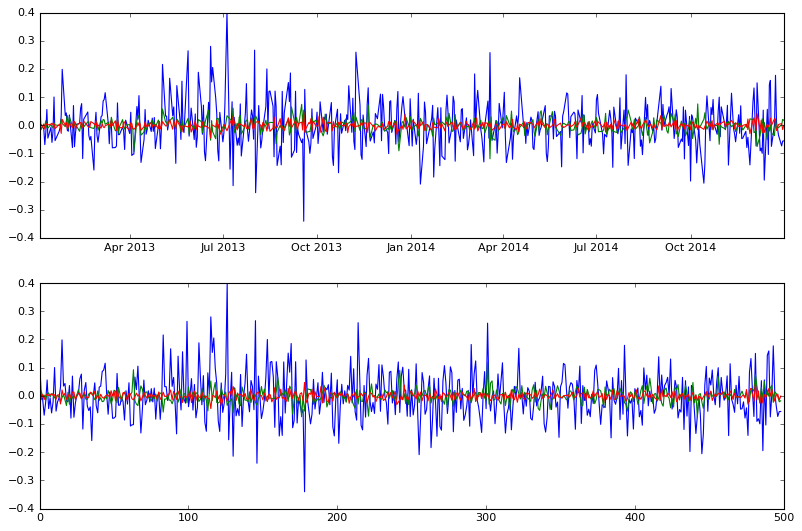

In [5]:
#first we test that our method is right
from sklearn.decomposition import PCA
dr=Sample1.diff()[1:]
x,v,pca_f=my_pca(dr,3)
plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.plot(pca_f)

plt.subplot(2,1,2)
pca=PCA(n_components=3)
pca_f=pca.fit_transform(dr)
plt.plot(pca_f);


### 1. PCA Decomposition

In [6]:
#we use the dr as the data
dr=Sample1.diff()[1:]
xcv_dr,vcv_dr,_=my_pca(dr,2)
print 'First two PCA factors:\n',vcv_dr[:,:2]


First two PCA factors:
[[ 0.00208684 -0.00749302]
 [ 0.17881042 -0.50113443]
 [ 0.47990958 -0.4661994 ]
 [ 0.53861583 -0.15507561]
 [ 0.50495686  0.18904928]
 [ 0.43888589  0.68678831]]


In [7]:
#Then we use r as the data
xcv_r,vcv_r,_=my_pca(Sample1,2)
print 'First two PCA factors:\n',vcv_r[:,:2]

First two PCA factors:
[[ 0.01612358 -0.0446742 ]
 [-0.08834891  0.31313604]
 [-0.49612349  0.49556528]
 [-0.57855181  0.21474743]
 [-0.52415308 -0.23678659]
 [-0.36923886 -0.74308866]]


### 2. Compute test statistics

In [8]:
FLY1=Sample1['2Y']-Sample1['5Y']+Sample1['10Y']
FLY2=Sample2['2Y']-Sample2['5Y']+Sample2['10Y']

In [9]:
X_dr=np.linalg.solve(vcv_dr[[1,4],:].T,vcv_dr[2,:])
print "For dr,the solution is:\n",X_dr

X_r=np.linalg.solve(vcv_r[[1,4],:].T,vcv_r[2,:])
print "For r,the solution is:\n",X_r

For dr,the solution is:
[ 1.13693977  0.54779512]
For r,the solution is:
[ 2.03850473  0.60292276]


In [10]:
"""
Weighted FLY: (2y)*w1-5y+(10y)*w2, w1,w2 are the weights 
"""
PCA_FLY1=Sample1['2Y']*X_dr[0]-Sample1['5Y']+Sample1['10Y']*X_dr[1]
PCA_FLY2=Sample2['2Y']*X_dr[0]-Sample2['5Y']+Sample2['10Y']*X_dr[1]
PCA_FLY1_r=Sample1['2Y']*X_r[0]-Sample1['5Y']+Sample1['10Y']*X_r[1]
PCA_FLY2_r=Sample2['2Y']*X_r[0]-Sample2['5Y']+Sample2['10Y']*X_r[1]


In [11]:
"""
COINT FLY is the Weighted FLY with weights chosen to make the Weighted FLY into the best cointegrated vector
"""
#from scipy.linalg import fractional_matrix_power
np.set_printoptions(3)
X=Sample1.loc[:,['2Y','5Y','10Y']].iloc[:-1]
Y=Sample1.loc[:,['2Y','5Y','10Y']].iloc[1:]
X=(X-np.mean(X))#/np.std(X)
Y=(Y-np.mean(Y))#/np.std(Y)
A=np.linalg.lstsq(X,Y)[0]
cov=Y.cov()
M=np.linalg.inv(cov).dot(A.T.dot(cov.dot(A)))
xcv_COINT,vcv_COINT=np.linalg.eig(M)
print "eigenvalue:",xcv_COINT
print "Eigen vector:\n",vcv_COINT
eig_sort=[(xcv_COINT[i],vcv_COINT[:,i]) for i in range(len(xcv_COINT))]
eig_sort.sort(key=lambda x:np.abs(x[0]))

w=eig_sort[0][1]*(-1.0)/eig_sort[0][1][1]
print 'weights for the portfolio:',w
COINT_FLY1=Sample1.loc[:,['2Y','5Y','10Y']].dot(w)
COINT_FLY2=Sample2.loc[:,['2Y','5Y','10Y']].dot(w)

eigenvalue: [ 0.805  1.006  0.98 ]
Eigen vector:
[[-0.865  0.365 -0.728]
 [ 0.424  0.593  0.685]
 [-0.269 -0.718 -0.029]]
weights for the portfolio: [ 2.042 -1.     0.635]


In [12]:
X=Sample1.loc[:,['2Y','10Y']]
Y1=Sample1.loc[:,'5Y']
reg_res=np.linalg.lstsq(X,Y1)[0]
w=-np.ones(3)
w[0]=(reg_res[0])
w[2]=(reg_res[1])
print 'weights for the portfolio:{}'.format(w)

weights for the portfolio:[ 1.668 -1.     0.319]


In [13]:
FLY_Sample1=pd.concat([FLY1,PCA_FLY1,PCA_FLY1_r,COINT_FLY1],axis=1)
FLY_Sample1.columns=['FLY1','PCA_FLY1','PCA_FLY1_r','COINT_FLY1']


FLY_Sample2=pd.concat([FLY2,PCA_FLY2,PCA_FLY2_r,COINT_FLY2],axis=1)
FLY_Sample2.columns=['FLY2','PCA_FLY2','PCA_FLY2_r','COINT_FLY2']
FLY_Sample2.head()

,FLY2,PCA_FLY2,PCA_FLY2_r,COINT_FLY2
Date,,,,
2015-01-02,1.17,0.301706,1.013609,1.083425
2015-01-05,1.15,0.320621,1.046146,1.113485
2015-01-06,1.12,0.318167,1.012786,1.077791
2015-01-07,1.11,0.308581,0.975602,1.040183
2015-01-08,1.15,0.316927,0.987806,1.054615


In [14]:
from statsmodels.tsa.stattools import adfuller
def test_stat(df):
    test_tastics=[adfuller(df.iloc[:,i])[0] for i in range(df.shape[1])]
    p_value=[adfuller(df.iloc[:,i])[1] for i in range(df.shape[1])]
    unit_root=['Reject' if i<0.05 else 'Fail' for i in p_value]
    return test_tastics,p_value,unit_root

test1=test_stat(FLY_Sample1)
test2=test_stat(FLY_Sample2)

In [15]:
test_df1=pd.DataFrame(list(test1),columns=FLY_Sample1.columns,index=['test statistic','p_values','Has Unit Root'])
test_df2=pd.DataFrame(list(test2),columns=FLY_Sample2.columns,index=['test statistic','p_values','Has Unit Root'])
test_df=test_df1.join(test_df2)
test_df

,FLY1,PCA_FLY1,PCA_FLY1_r,COINT_FLY1,FLY2,PCA_FLY2,PCA_FLY2_r,COINT_FLY2
test statistic,-1.23464,-1.51521,-3.85726,-3.97585,-1.14728,-0.765028,-0.788987,-0.811404
p_values,0.658519,0.525976,0.00237294,0.00154237,0.695852,0.82918,0.822336,0.815749
Has Unit Root,Fail,Fail,Reject,Reject,Fail,Fail,Fail,Fail


In [16]:
test3=test_stat(FLY_Sample2.diff()[1:])
print test3

([-18.519412516908844, -20.625289096343401, -18.527886099796493, -18.461384223382282], [2.1096411583050729e-30, 0.0, 2.1048345371890633e-30, 2.1464889347771052e-30], ['Reject', 'Reject', 'Reject', 'Reject'])


In order to make sure that I understand the CCA right. I wrote my thoughts about CCA.

1. For the time series, subtract the mean.
2. $Y_t = Y_{t-1}A+\Sigma $ Solve A for the regression
3. $M=C^{-1}A^TCA, \text{where C is the covariance matrix of Y_t. }$ **This is a little different from the lecture 2 slides. **
4. The weight is the eigenvector for the smallest eigenvalue

### Summary
Summarize the result:
1. For FLY, the statistical test fails to reject the unit root.
2. For PCA neutral portfolio, it is not stationary for sample1 and sample2.
3. For CCA cointegration vector, the weights are decided by 2Y,5Y,10Y in Sample1 and the test rejects the unit root. But the weight cannot make the sample two a cointegrated vector.
4. For dr, for all the portfolio, the test rejects the unit root.